### Introduction to transaction costs in backtesting

백테스팅의 현실성과 효과성은 거래 비용을 정확히 고려하는 데 크게 의존한다. 이러한 비용은 거래 전략의 수익성과 실행 가능성에 상당한 영향을 미칠 수 있다. 매우 현실적인 백테스팅을 원한다면 가장 가까운 것은 event driven engine을 사용하는 것이며, 벡터화된 백테스팅은 단지 추정치를 제공할 뿐이며, 이는 90%의 전문 트레이더에게 충분하다

백테스트에서 트레이더가 고려해야 할 거래 비용의 세 가지 주요 유형은 다음과 같다

1. Commissions

수수료는 브로커가 거래를 실행하는 데 부과하는 수수료이다. 이는 브로커의 가격 구조, 자산 클래스, 거래량에 따라 크게 다를 수 있다. 수수료는 거래당 고정 수수료, 거래 가치의 일정 비율, 또는 거래된 주식이나 계약의 수에 따라 부과될 수 있다

- Best practice
    - 브로커별 계산: 백테스트에서 수수료 구조가 실제 거래에 사용할 브로커의 구조를 반영하도록 한다
    - 단계적 구조: 브로커가 단계적 수수료 구조를 사용하는 경우, 백테스트에서 다양한 거래량 임계치에서 변동하는 요금을 고려한다
    - 전략에 대한 영향: 일일 거래나 고주파 거래와 같이 빈번한 거래를 포함하는 전략에 주의를 기울이며, 수수료 비용이 빠르게 누적되어 순수익에 상당한 영향을 미칠 수 있다

2. Bid-ask spread

매수-매도 스프레드는 구매자가 지불할 의향이 있는 가장 높은 가격(매수가)과 판매자가 받아들일 의향이 있는 가장 낮은 가격(매도가) 사이의 차이이다. 이 스프레드는 트레이더에게 비용이며, 스프레드가 더 넓은 유동성이 낮은 자산에 특히 중요하다

- Best practice
    - 역사적 스프레드: 전략에서 사용하는 자산의 평균 스프레드를 추정하기 위해 역사적 스프레드 데이터를 활용한다
    - 일중 거래: 일중 거래 전략의 경우, 거래일 내내 크게 변할 수 있는 스프레드 데이터를 사용한다
    - 자산 유동성: 유동성이 낮은 자산은 종종 더 넓은 스프레드를 가지며, 특히 큰 거래에서 이익을 침식할 수 있으므로 이를 고려한다

3. Market impact

시장 영향은 트레이더의 주문이 자산의 시장 가격에 미치는 영향을 말한다. 특히 큰 주문의 경우, 트레이더의 활동이 시장 가격을 변화시켜 슬리피지(거래가 예상 가격과 실제 체결 가격 사이의 차이)를 발생시킬 수 있다

- Best practice
    - 크기가 중요합니다: 주문이 시장 거래량에 비해 상대적으로 클수록 잠재적인 시장 영향이 더 클 수 있다. 대규모 거래를 포함하는 전략에 이를 반영한다
    - 시장 영향 모델링: 선형 비용 모델이나 주문 크기의 제곱근에 비례한다고 제안하는 제곱근 모델과 같은 시장 영향 모델을 활용한다
    - 적응형 전략: 큰 주문을 작은 주문으로 나누거나 시장 상황에 적응하는 알고리즘 실행 전략과 같이 시장 영향을 최소화하는 전략을 고려한다

#### Extra costs

추가적으로 다음의 비용을 추가할 수 있다 (vectorized setting에서 이를 추가한 사람은 많지 않다)

- 공매도 차입 비용
- Forex를 위한 환율 및 자금 조달 비용

---

#### Replicate the momentum strategy

아래는 이전 튜토리얼에서 구축한 변동성 목표 모멘텀 전략을 복제한다

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import quantstats as qs
import matplotlib.pyplot as plt

**Fetching SPX Adjusted close price data from Yahoo Finance**

In [3]:
spx = yf.download('SPY', start = '2000-01-01', end = '2024-01-01')

close_prices = spx['Close']
volume = spx['Volume']

[*********************100%%**********************]  1 of 1 completed


**vilsualizing S&P 500 closing prices**

시장 트랜드를 더 잘 이해하기 위해서 데이터를 시각화한다. 아래의 그림은 S&P 500의 종가를 보여준다

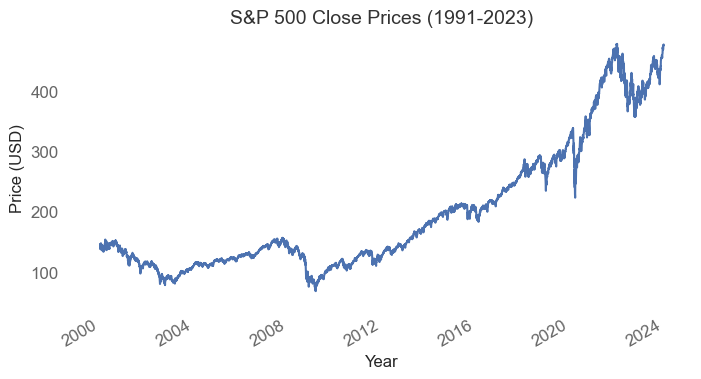

In [5]:
# Plotting the S&P 500 closing prices
close_prices.plot(figsize = (8, 4), linewidth = 1.5)
plt.title('S&P 500 Close Prices (1991-2023)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(False)
plt.show()

#### Moving average crossover strategy from previous tutorial

In [6]:
short_window = 50
long_window = 252

short_ma = close_prices.rolling(window = short_window, min_periods = short_window).mean()
long_ma = close_prices.rolling(window = long_window, min_periods = long_window).mean()

generating trading signals

In [7]:
signals = pd.DataFrame(index = close_prices.index)
signals['signal'] = 0.0 # set the default to be 0
signals['short_moving_average'] = short_ma
signals['long_moving_average'] = long_ma

long moving average보다 short moving average가 위로 올라갈 경우 buy signal을 발생시키고, 반대의 경우 sell signal을 발생시킨다. 간단하게 이 signal을 -1 혹은 1을 사용한다

In [8]:
signals['signal'][signals['short_moving_average'] > signals['long_moving_average']] = 1
signals['signal'][signals['short_moving_average'] < signals['long_moving_average']] = -1

volatility target을 추가한다

In [9]:
target_vol = 0.15

daily return을 계산하고 아래와 같이 밴드를 형성한다

In [10]:
spx_returns = close_prices.pct_change()
signals['stdev'] = spx_returns.rolling(22).std() * np.sqrt(252) # convert to annualized standard deviation
signals['volatility_target'] = target_vol / signals['stdev']

# Clip weights to a maximum of 1 to avoid leverage
# Here we use 2x leverage to make sure we can hit our volatility target of 15%
signals['volatility_target'] = signals['volatility_target'].clip(0, 2)

In [11]:
# Adjust the signal by the volatility target, lagging both to avoid look-ahead bias
vol_signal = signals['signal'].shift(1) * signals['volatility_target'].shift(1)

# Compute returns for the volatility-targeted strategy
strategy_voltgt_returns = spx_returns * vol_signal

plot the cumulative returns (compounded growth)

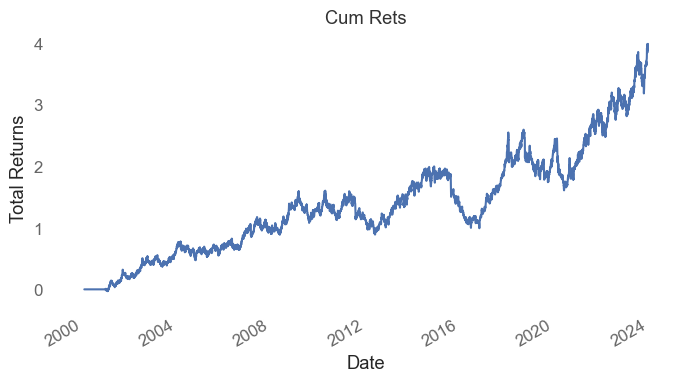

In [13]:
((strategy_voltgt_returns + 1).cumprod()-1).plot(title = 'Cum Rets', figsize = (8, 4))
plt.grid(False)
plt.ylabel('Total Returns')
plt.show()

---

#### Computing turnover to calculate transaction costs

거래 활동을 통해 주로 발생하는 거래 비용을 효과적으로 측정하기 위해서는 턴오버에 중점을 두는 것이 중요하다. 이 문맥에서 Turnover는 포트폴리오 내의 거래 빈도와 거래량을 의미한다

Turnover는 우리의 포지션에서의 일일 변동을 측정함으로써 이를 한 단계 더 발전시킨다. 본질적으로, 이는 포트폴리오 내에서 증권이 얼마나 빈번하게 교체되거나 "회전"되는지를 나타내는 비율이다. 이 지표는 하루에서 다음 날까지의 포지션 크기의 절대 차이로 계산되며, 우리가 얼마나 자주 그리고 현저하게 보유 자산을 조정하는지에 대한 명확한 청사진을 제공한다. Turnover를 이해하고 계산하는 것은 거래 비용 발생 빈도와 직접적으로 관련이 있으며, 따라서 거래 전략의 전반적인 성과에 영향을 미친다

참고:

Turnover를 -1만큼 이동시키는 것이 중요하다. 왜냐하면 vol_signal은 시간 t에서 우리가 보유한 포지션이며, 우리가 알아야 할 것은 거래가 발생한 날짜인데, 그것은 전날이기 때문이다

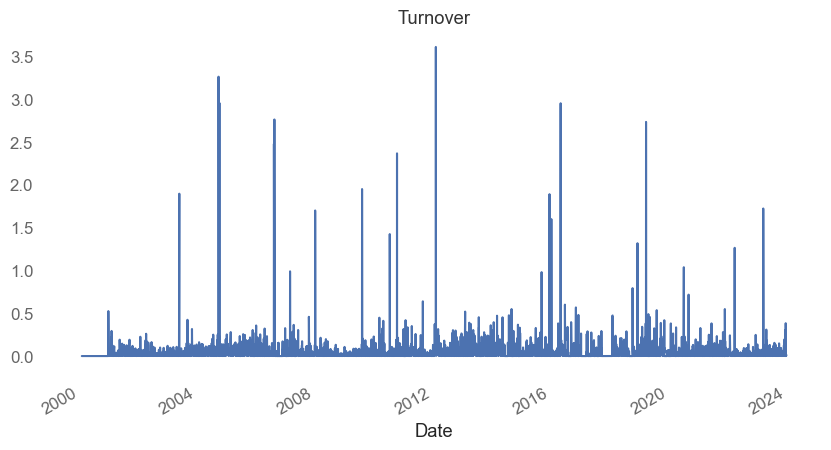

In [14]:
turnover = abs(vol_signal.diff())

# Shift by -1 to get the date at which the transaction occurred, which was at close yesterday.
turnover = turnover.shift(-1)

# Plot Turnover
turnover.plot(title = 'Turnover', figsize = (10, 5))
plt.grid(False)
plt.show()

#### Incorporating Brokerage Fees in backtesting

브로커리지 수수료는 거래 전략의 수익성에 있어 중요한 요소로, 브로커마다 크게 다르며 일반적으로 basis point(bp)로 측정된다. basis point는 금융에서 사용되는 단위로, 금융 상품의 가치 또는 비율 변화를 설명하기 위해 사용된다. 1 basis point는 0.01% (1/100퍼센트) 또는 소수점으로 0.0001과 동일하다. 예를 들어, 브로커가 수수료로 10 basis point를 부과한다면, 그들은 거래 가치의 0.10%를 청구하는 것이다

헤지펀드에서 초기 경력을 쌓을 때, 보통 거래당 14에서 20 basis point 범위의 브로커리지 수수료를 흔히 접할 수 있다. 이러한 비용은 매우 변동적이며, 운영 규모와 브로커와의 관계 성격과 같은 요인에 크게 의존한다. 대규모 펀드는 높은 거래량으로 인해 낮은 수수료를 협상하는 경우가 많으며, retail trader는 일반적으로 더 높은 요금을 마주하게 된다

흥미롭게도, 일부 펀드에서는 거래가 실제로 리베이트를 발생시켜, 거래를 위한 보상을 제공하기도 한다. 이것은 거래 비용이 소속된 조직에 따라 매우 특정할 수 있음을 보여주는 주요 예시이다

백테스팅에 브로커리지 수수료를 적용할 때 중요한 것은 다음과 같다

- 정확한 수수료 조사 및 사용: 당신의 펀드 또는 개인 거래 시나리오에 적용되는 구체적인 브로커리지 수수료를 결정한다. 이는 브로커의 수수료 구조를 이해하고 이러한 수수료를 베이시스 포인트로 변환하여 정확한 계산을 하는 것을 요구한다

- 펀드의 규모 고려: 펀드가 클수록 그리고 거래량이 많을수록 협상된 수수료가 낮을 수 있다. 해당되는 경우 이러한 협상된 요금을 Backtesting model에 포함시킨다

- 소매 대 기관 차이 고려: 소매 트레이더로서 전략을 Backtesting하는 경우, 소매 거래 계좌에 적용되는 수수료율을 사용해야 한다. 이는 일반적으로 기관 트레이더에게 적용되는 요금보다 높다

- 리베이트 고려: 거래 전략 또는 거래량이 리베이트에 해당하는 경우, 이를 Backtesting의 비용 계산에 반영해야 한다. 이는 거래의 비용-편익 분석에 큰 영향을 미칠 수 있다

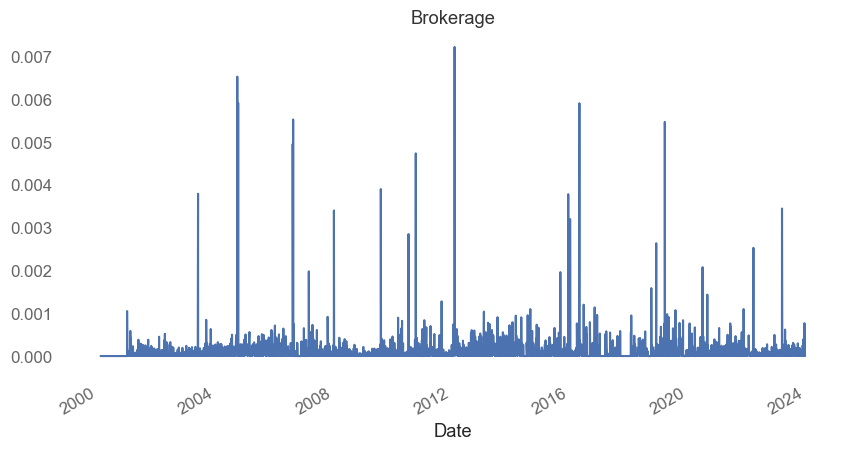

In [15]:
brokerage_fees = 0.0020 # 20 basis points
brokerage = turnover * brokerage_fees

# Plot Brokerage
brokerage.plot(title = 'Brokerage', figsize = (10, 5))
plt.grid(False)
plt.show()

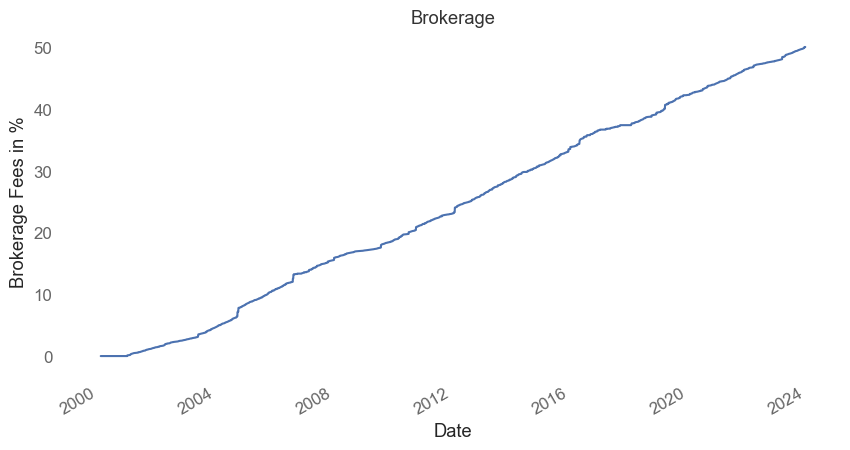

In [16]:
# Plot Cum Brokerage
(brokerage.cumsum() * 100).plot(title = 'Brokerage', figsize = (10, 5))
plt.grid(False)
plt.ylabel('Brokerage Fees in %')
plt.show()

영향 : 무려 50% 가까이를 20 basis point의 수수료가 차지한다

#### Accounting for Bid-Ask spread

백테스팅에서 매수-매도 스프레드를 포함하는 것은 미묘한 결정이며, 종종 거래 전략의 성격에 따라 달라진다. 벡터화된 백테스팅에서는 이 문맥에서 상대적으로 미미한 영향 때문에 보통 매수-매도 스프레드를 생략한다. 그러나 이 요소는 intra-day trading 전략에서 훨씬 더 중요해진다. 여기서는 매수-매도 스프레드와 같은 작은 변동조차도 성과에 실질적인 영향을 미칠 수 있다

이러한 전략에서 매수-매도 스프레드를 효과적으로 고려하기 위해서는 각 거래 시점의 최적 매수가와 최적 매도가를 포함한 자세한 시장 데이터에 접근할 필요가 있다. 이러한 세부 정보는 실제 거래 시나리오에서 마주칠 비용을 더 정확히 시뮬레이션할 수 있게 해준다

이 예제에서는 평균 스프레드를 사용한다. ETF.com과 같은 신뢰할 수 있는 온라인 출처를 참조하면, SPY(인기 있는 S&P 500 ETF)와 같은 ETF의 평균 매수-매도 스프레드는 대략 0.000032로, 이는 0.32 베이시스 포인트에 해당한다. 이 수치는 비록 작게 보일 수 있지만, 특히 High-frequency trading 환경에서 많은 거래가 누적되면 중요해질 수 있다

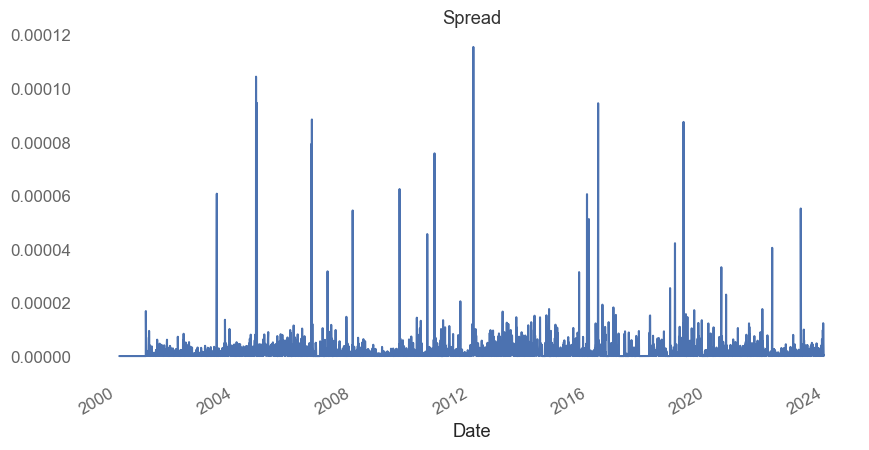

In [17]:
bid_ask_fee = 0.000032 # 0.32 basis points
spread = turnover * bid_ask_fee

# Plot Spread
spread.plot(title = 'Spread', figsize = (10, 5))
plt.grid(False)
plt.show()

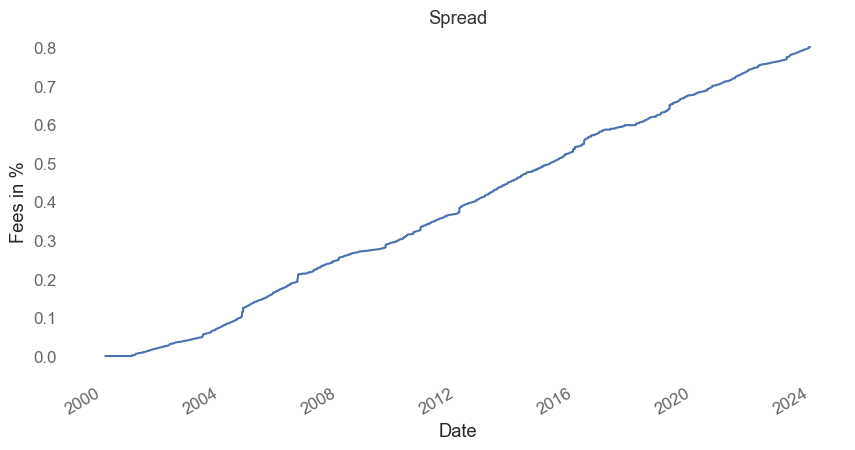

In [18]:
# Plot Cum Spread
(spread.cumsum()*100).plot(title = 'Spread', figsize = (10, 5))
plt.grid(False)
plt.ylabel('Fees in %')
plt.show()

영향 : 0.8%의 수수료를 대략 24년의 기간동안 지불한다

#### Integrating Slippage (Market impact)

벡터화된 Backtest에서 slippage 또는 market impact을 포함하는 것은 미묘한 과정이다. 간단함과 실용성을 위해, 일반적으로 거래당 고정된 슬리피지 값을 사용한다. 그러나 더 정교한 백테스팅 프레임워크에서, 예를 들어 이벤트 기반 시스템이나 반복 루프를 사용하는 경우에는 슬리피지에 대한 동적 접근이 종종 더 정확하다. 이 경우, linear model은 slippage를 추정하기 위한 일반적인 선택이다

**슬리피지 이해하기**

slippage는 거래가 실행될 예상 가격과 실제 실행 가격 사이의 차이를 나타낸다. 이 차이는 빠르게 움직이는 시장이나 큰 주문을 다룰 때 특히 중요할 수 있다

**주요 포인트는 다음과 같다**

- 간소화된 접근법: 벡터화된 백테스팅에서는 그 집계적이고 간소화된 성격으로 인해, 거래당 고정된 슬리피지 값을 사용하는 것이 시장 영향을 대략적으로 추정하는 실용적인 방법이 될 수 있다
- 이벤트 기반 및 반복 모델: 이보다 더 자세한 백테스팅 모델은 다양한 시장 조건과 주문 크기에 맞게 슬리피지를 더 미묘하게 접근할 수 있다
- 고급 기술:
    - 범위를 벗어남: 슬리피지에 대한 기관급 추정 기술은 복잡한 수학을 포함하며 이 과정의 범위를 벗어나 있다. 그러나 몇몇의 학생들은 관심이 있다면 이러한 고급 내용을 포함하는 것에 열려 있다
    - 실용적인 지침: Udacity의 AI in Trading 코스에서 강조한 접근방식은 "거래가 평균 일일 거래량의 1%를 구성할 때 가격이 약 10 베이시스 포인트만큼 변동될 수 있다"는 것이다. 그러면 거래 비용은 거래된 금액에 곱해진 가격 변동 백분율로 추정될 수 있다
        
이러한 슬리피지 통합 접근법은 현실성과 계산적 간소함 사이의 균형을 맞춘다. 학생들이 이 방법의 한계를 이해하고, 고급 거래 시나리오에서 더 복잡하고 동적인 모델의 가능성을 인식하는 것이 중요하다. 심지어 간소화된 슬리피지 버전을 포함함으로써, 트레이더들은 전략의 성능에 대한 더 현실적인 평가를 달성할 수 있다

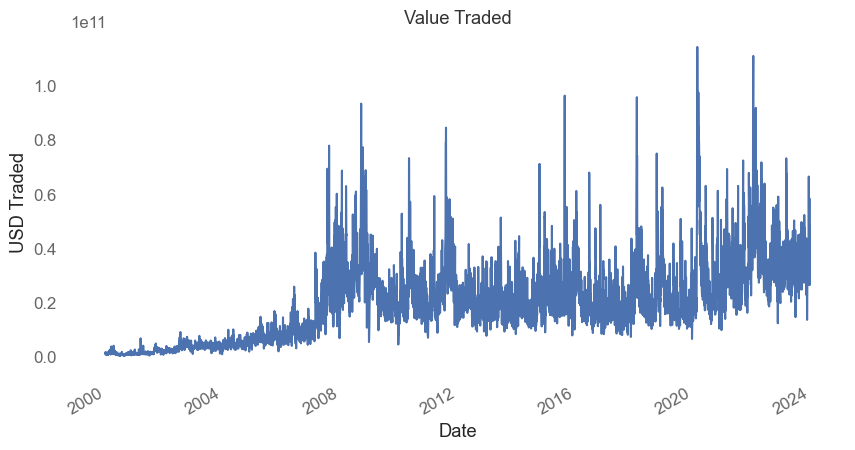

In [20]:
# Volume on SPY is massive, we are probably never going to be 1% of ADV
daily_value = volume * close_prices
daily_value.plot(title = 'Value Traded', figsize = (10, 5))
plt.grid(False)
plt.ylabel('USD Traded')
plt.show()

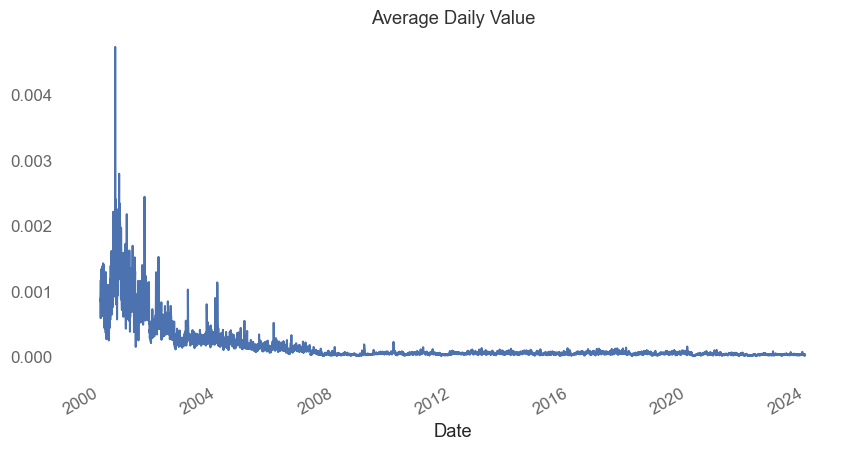

In [21]:
# Lets assume we are going to have a maximum of 1'000'000 USD traded on any day
# Therefor
adv = 1000000 / daily_value
adv.plot(title = 'Average Daily Value', figsize = (10, 5))
plt.grid(False)
plt.show()

Here you can see, we never reach that value.

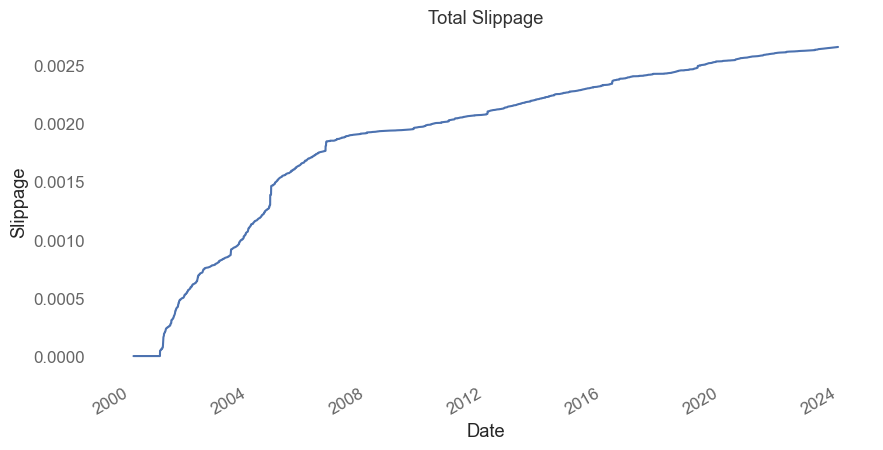

In [22]:
# Lets use this to compute slippage costs, linearly (This is not the Linear Model)
# If 1% = 10 basis points then every 10 basis points of ADV can be 1 basis point of slippage.
cost = (adv / 0.01) * 0.0010
slippage = cost * turnover

# Plot total slippage
slippage.cumsum().plot(title = 'Total Slippage', figsize = (10, 5))
plt.grid(False)
plt.ylabel('Slippage')
plt.show()

**Notes**

- 전체 슬리피지: 하루에 최대 100만 달러의 거래를 가정할 때 전체 기간에 걸쳐 25 베이시스 포인트 미만이다
- 초기 고비용 관찰: 거래 초기 단계에서 거래 비용이 상당히 높다는 것을 알 수 있다. 이는 2004년 이전에 평균 일일 거래량(ADV)이 상당히 높았기 때문입니다. 지수가 인기를 얻고 거래량이 증가함에 따라 이러한 비용은 감소하는 경향이 있다
- 벡터화된 백테스팅에서의 슬리피지 접근: 벡터화된 백테스팅은 계산 효율성을 제공하지만, 이 방법에서 상세한 슬리피지 계산을 생략하는 것이 일반적으로 권장된다. 그 이유는 벡터화된 백테스팅이 슬리피지를 정확하게 시뮬레이션하는 데 필요한 세부적인 정보를 제공하지 못하기 때문이다. 대신, 슬리피지는 for-loop이나 이벤트 기반 백테스팅 프레임워크 내에서 더 효과적으로 계산되며, 여기서 각 거래별로 더 정밀한 모델을 적용할 수 있다
- 유동성이 슬리피지에 미치는 영향: 유동성이 낮은 주식에서는 슬리피지가 더 두드러지는 경향이 있다. 이러한 경우, 상대적으로 작은 주문도 시장 가격에 상당한 영향을 미칠 수 있으며, 이는 거래의 예상 가격과 체결 가격 사이의 더 큰 격차로 이어진다. 이 요소는 유동성이 낮은 자산을 다루거나 자산의 거래 활동에 비해 큰 거래량을 포함하는 전략에 특히 중요하다

#### Total costs

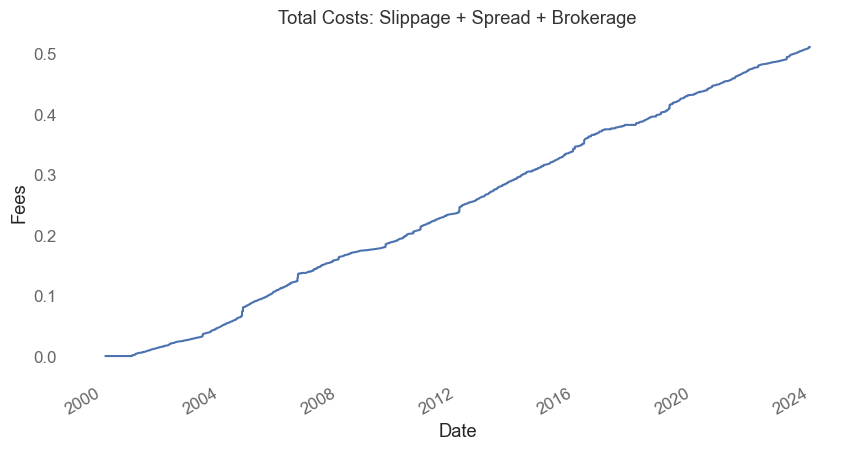

In [23]:
total_costs = brokerage + spread + slippage

# Plot total costs
total_costs.cumsum().plot(title='Total Costs: Slippage + Spread + Brokerage', figsize=(10, 5))
plt.ylabel('Fees')
plt.grid(False)
plt.show()

#### comparing the strategy with and without transaction costs

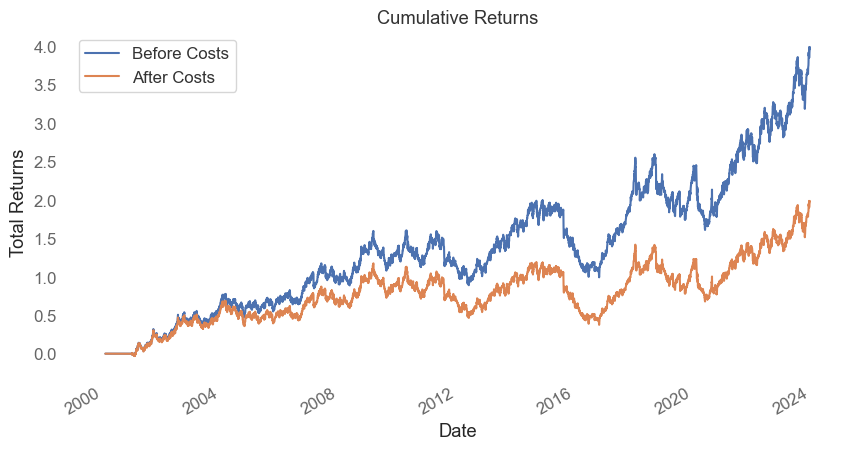

In [25]:
# Plot the cumulative rets (compounded growth)
# Before costs
((strategy_voltgt_returns + 1).cumprod() - 1).plot()

# After Costs
after_cost = strategy_voltgt_returns - total_costs 
((after_cost + 1).cumprod()-1).plot(figsize = (10, 5))

# Plot Cum returns
plt.title('Cumulative Returns')
plt.legend(['Before Costs', 'After Costs'])
plt.ylabel('Total Returns')
plt.grid(False)
plt.show()

In [28]:
sr_before = strategy_voltgt_returns.mean() / strategy_voltgt_returns.std() * np.sqrt(252)
sr_after = after_cost.mean() / after_cost.std() * np.sqrt(252)

print(f'Sharpe Ratio Before: {sr_before.round(2)}')
print(f'Sharpe Ratio After: {sr_after.round(2)}')

Sharpe Ratio Before: 0.5
Sharpe Ratio After: 0.37


#### Conclusion

이러한 거래 비용을 백테스트 모델에 정확하게 포함시키는 것은 전략의 성과를 현실적으로 평가하는 데 필수적이다. 이러한 비용을 과소평가하면 전략에 대한 과도한 낙관적인 평가를 초래할 수 있고, 과대평가하면 잠재적으로 수익성이 높은 전략을 과도하게 폐기할 수 있다. 핵심은 과거 데이터와 현실적인 가정을 사용하여 실제 거래에서 직면한 조건을 면밀히 반영하여 균형을 맞추는 것이다